In [19]:
### Load basic libraries ###
import glob
import os
import sys
import logging

import numpy as np
from numpy import size

import tensorflow as tf
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))

import matplotlib.pyplot as plt
from matplotlib.pyplot import text, legend

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
### Load audio libraries ###
import librosa
import librosa.display

from audiomentations import AddGaussianNoise
from IPython.display import Audio

# Defs: Global Configuration variables

In [21]:
# Debug and test variables
REDUCED_MODE = 0 # Do not process all the sound in the dataset (for faster execution during script development)
REDUCED_MODE_SOUNDNUM = 99999 # Number of dataset sounds per folder to process in the reduced-mode.

# sound processing variables
SOUND_SR = 44100  # sound sampling in Hertz
SOUND_F_FFT = 2048  # Samples per FFT window
SOUND_HOP_LEN = 512 # Hop Length
SOUND_N_MELS = 25 # Number of mel frequencies to analyze

SOUNDSEG_SIZE = 82 #82 / 41  # windows per subsound / segment
SOUNDSEG_OVERLAP = 0.4  # 40% overlapping factor for engine sounds

SOUNDSEG_OVERSAMPLING = 4  # how many times to increase the engine category samples
SOUNDSEG_CLASS2OVERSAMPLE = 5  # Oversample the engine class (num. 5)

# Preprocessing
PREPROC_SKIP = 0  # Skip preprocessing files and use previosuly saved '.npz'

# CNN Processing
CNN_EPOCHS = 20
CNN_LEAKYRELU = 1
CNN_BATCHSIZE = 32
CNN_KERNELSIZE = (3,3)
CNN_POOLSIZE = (2,2)

# Paths and folders
soundsPath = 'UrbanSounds8K/1_audioFiles/'
soundsSubPaths = np.array(['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10'])
preProcPath = "UrbanSounds8K/2_featuresProcessed/"
trainingResultsPath = "UrbanSounds8K/3_trainingResults/"
logPath = "UrbanSounds8k/4_executionLog/"

confusionFile = "confusion_matrix"
trainingFile = "trainingResults"
metricsFile = "metrics"

# Defs: Data displaying and logging to file

In [22]:
# Setup logging both in console and file
if not 'procLog' in vars():
    sHand = logging.StreamHandler();
    procLog = logging.getLogger('PreProc')
    logging.basicConfig(level = logging.INFO,
     filename = logPath + 'executionLog.log',
      filemode = 'w', format = '%(asctime)s :: %(message)s',
      datefmt='%d-%b-%y %H:%M:%S');
    procLog.addHandler(sHand);


# Defs: Preprocessing and feature extraction from audios

In [23]:
# Divide an sound file into shorter and overlapped parts.
def soundSegmentation(soundSignal, subsoundSize, overlapFactor=SOUNDSEG_OVERLAP):
    start = 0
    while start < len(soundSignal):
        yield int(start), int(start + subsoundSize)
        start += (subsoundSize // (1/(1-overlapFactor)))

# Add white noise to signal respecting a maximum amplitude based on RMS energy of the original signal
def soundAddGaussianNoise(soundSignal, sampleRate = SOUND_SR, maxAmplitude_percRMS = 0.1):
    signalRMS = (np.average(soundSignal**2))**(1/2);
    
    randomFact1 = np.random.rand(1);
    randomFact2 = np.random.rand(1);

    factMax =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 > randomFact2 else randomFact2);
    factMin =  signalRMS * maxAmplitude_percRMS * (randomFact1 if randomFact1 < randomFact2 else randomFact2);

    transform = AddGaussianNoise(min_amplitude=factMin, max_amplitude=factMax,p=1);
    augSoundSignal = transform(soundSignal,sample_rate=44100);

    return augSoundSignal

# Load sound with Librosa and make it faster or slower (time stretching)
def soundLoadAndStretch(soundPath, sampleRate = SOUND_SR, maxStretch = 0.1):
    randomFact = (np.random.rand(1) - 0.5) * maxStretch;
    soundSignal, sr = librosa.load(soundPath, sr=SOUND_SR * (1+maxStretch));
    return soundSignal;

In [24]:
# Extract features from sound files, generating spectogram segments (images)
def extractSoundFeature(soundsPath, soundsSubPath, n_mels=SOUND_N_MELS, n_windows=SOUNDSEG_SIZE, hopLength=SOUND_HOP_LEN,
                        soundOversamplingFact=SOUNDSEG_OVERSAMPLING, soundOverClass=SOUNDSEG_CLASS2OVERSAMPLE):

    subsoundSize = hopLength * (n_windows - 1)
    features_AM, origClasses_A, segSounds_AA = [], [], []

    # Map all sound samples paths inside the folder
    allsoundsPath_A = glob.glob(os.path.join(soundsPath, soundsSubPath, "*.wav"))

    # Iterate and extract features from each sound
    idxSound, idxSegment = 0, 0
    for soundPath in allsoundsPath_A:
        idxSound = idxSound+1
        # Early stop for reduced mode
        if REDUCED_MODE == 1 and idxSound == REDUCED_MODE_SOUNDNUM:
            break

        # Extract sound class by parsing file name
        soundClass = int(soundPath.split('/')[2].split('-')[1])

        # Loop more than once in the same sound (oversampling) if is engine class (5)
        if soundClass == soundOverClass:
            maxRepeatOverSampl = soundOversamplingFact  # Oversampling by repetition
            overlapFactor = SOUNDSEG_OVERLAP  # Oversampling by overlapping
        else:
            maxRepeatOverSampl = 1
            overlapFactor = 0

        idxOverSampl = 0
        for idxOverSampl in np.arange(maxRepeatOverSampl):

            # Extract '.wav' sound to an 1-D array and apply stretching if required
            if idxOverSampl > 0:
                soungSignal_A = soundLoadAndStretch(soundPath, SOUND_SR, 0.1)  # stretch
            else:
                soungSignal_A = soundLoadAndStretch(soundPath, SOUND_SR, 0.0)  # don't stretch

            # Create subsegments from sound file and extract the features
            segSoundSignal_AA, segSoundSpect_AM, segSoundClass_A = [], [], []  # Init arrays
            for (start, end) in soundSegmentation(soungSignal_A, subsoundSize, overlapFactor):
                if (len(soungSignal_A[start:end]) == subsoundSize):
                    idxSegment = idxSegment+1

                    # Append sound class to segments class array
                    segSoundClass_A.append(soundClass)

                    # Extract segment from sound data - 1D Array
                    segSoundSignal_A = soungSignal_A[start:end]
                    segSoundSignal_AA.append(segSoundSignal_A)  # All segs. array

                    # Apply data augmentation if repeated loop
                    if idxOverSampl > 0:
                        segSoundSignal_A = soundAddGaussianNoise(segSoundSignal_A, SOUND_SR, 0.1)

                    # Transform to spectogram in decibels - 2D Matrix
                    segsoundSpect_M = librosa.feature.mfcc(y=segSoundSignal_A, n_mfcc=n_mels)

                    # Reshape and append to preprocessed spectograms
                    #segsoundSpect_M = segsoundSpect_M.T.flatten()[:, np.newaxis].T
                    segsoundSpect_M = segsoundSpect_M.flatten()[:, np.newaxis] # wrng transp fix
                    segSoundSpect_AM.append(segsoundSpect_M)

            segSoundSpect_AM = np.asarray(segSoundSpect_AM).reshape(len(segSoundSpect_AM), n_mels, n_windows, 1)

            # If last sound not empty, stack together with others
            if len(segSoundSpect_AM) > 0:
                segSounds_AA.append(segSoundSignal_AA)
                features_AM.append(segSoundSpect_AM)
                origClasses_A.append(segSoundClass_A)
    
    procLog.log(msg = '-> Num of segments for '+ soundsSubPath +' -> ' + str(idxSegment) + 
                ' - out of - ' + str(idxSound) + ' sounds.', level=20)

    # Stack all data 'per segment' and not 'per sound'
    segSounds_AA = np.concatenate(segSounds_AA, axis=0)
    features_AM = np.concatenate(features_AM, axis=0)
    origClasses_A = np.concatenate(origClasses_A, axis=0)

    # Convert UrbanSounds8K class to binary 'is/isn't engine'
    engineClasses_A = np.array(
        list(map(lambda x: 1 if x == 5 else 0, origClasses_A)))

    return segSounds_AA, features_AM, engineClasses_A


# Defs: CNN Model

In [25]:
# Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu=0):
    keras.backend.clear_session()

    pool_size = CNN_POOLSIZE
    kernel_size = CNN_KERNELSIZE
    input_shape = (SOUND_N_MELS, SOUNDSEG_SIZE, 1)
    num_classes = 2  

    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same",  input_shape=input_shape, dilation_rate=1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size,
              padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Dropout(0.2))

    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    initial_learning_rate = 1e-4
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=1500, decay_rate=0.85, staircase=True)

    model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model


# Proc: Sound Processing and Features Extraction

-> Num of segments for fold1 -> 5307 - out of - 873 sounds.
   MC: 2737   / NMC:  2570
   MC: 0.5157339363105332%  / NMC:  0.48426606368946673%
-> Num of segments for fold2 -> 5372 - out of - 888 sounds.
   MC: 2691   / NMC:  2681
   MC: 0.5009307520476545%  / NMC:  0.4990692479523455%
-> Num of segments for fold3 -> 5733 - out of - 925 sounds.
   MC: 2935   / NMC:  2798
   MC: 0.5119483690912262%  / NMC:  0.4880516309087738%
-> Num of segments for fold4 -> 5892 - out of - 990 sounds.
   MC: 3053   / NMC:  2839
   MC: 0.5181602172437203%  / NMC:  0.4818397827562797%
-> Num of segments for fold5 -> 5632 - out of - 936 sounds.
   MC: 2854   / NMC:  2778
   MC: 0.5067471590909091%  / NMC:  0.4932528409090909%
-> Num of segments for fold6 -> 5371 - out of - 823 sounds.
   MC: 2482   / NMC:  2889
   MC: 0.46211133867063864%  / NMC:  0.5378886613293614%
-> Num of segments for fold7 -> 5424 - out of - 838 sounds.
   MC: 2600   / NMC:  2824
   MC: 0.47935103244837757%  / NMC:  0.52064896755162

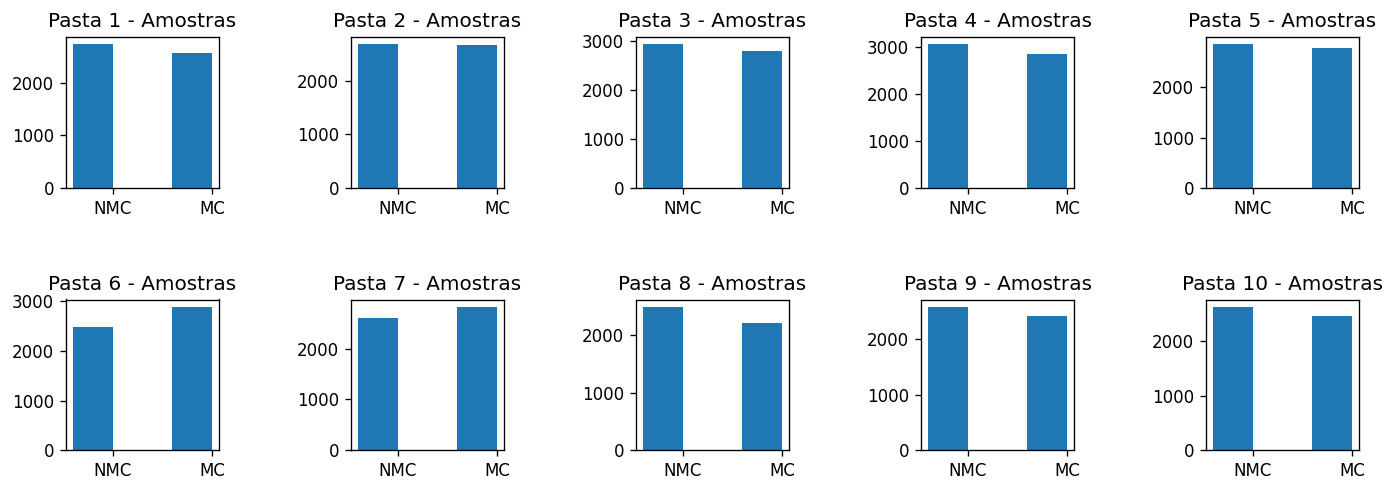

In [26]:
# Pre-process and extract feature from the data
if PREPROC_SKIP == 0:
    fig, axes = plt.subplots(2, 5, dpi=120);
    axes = axes.ravel();
    fig.set_figheight(10*0.5); fig.set_figwidth(25*0.5); fig.tight_layout(pad=4.5);

    # Loop through all sound folders
    idxFold = 0
    for soundSubPath in soundsSubPaths:
        # Extract files from folder and save externally for reuse
        segSounds_AA, features_AM, classes_A = extractSoundFeature(soundsPath, soundSubPath)
        np.savez("{0}{1}".format(preProcPath, soundSubPath), segSounds = segSounds_AA, features=features_AM, classes=classes_A);
        # Plot histogram of data balancing per folder
        axes[idxFold].set_title('Pasta ' + str(idxFold+1) + ' - Amostras')
        tmpData = np.asarray(classes_A)
        tmpData = [np.count_nonzero(tmpData == 0), np.count_nonzero(tmpData == 1)]
        procLog.log(msg = '   MC: '+ str(tmpData[0])  +'   / NMC:  ' + str(tmpData[1]), level=20);
        procLog.log(msg = '   MC: '+ str(tmpData[0]/ (tmpData[0] + tmpData[1]))  +
        '%  / NMC:  ' + str(tmpData[1]/ (tmpData[0] + tmpData[1])) + '%', level=20);

        axes[idxFold].bar(['NMC', 'MC'], tmpData,
                          align='edge', width=-0.4, label="Train")
        idxFold += 1
    fig.savefig(fname = logPath + '1_foldersProcessing.jpg' );
            

# Proc:  CNN Training and Testing

In [27]:
### Train and evaluate via 10-soundsSubPaths cross-validation ###
kf = KFold(n_splits=10);

# List containing all confusion matrix for all K-Fold Train-Test.
# Array containing the results of the training for each train/test set.
allConfusionMatrix_AM, allFitHistory_AO = [], [];
bestConfusionMatrix_AM, bestConfusionMatrixAbs_AM = [], [];

# Loop to train-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(soundsSubPaths):
    idx = idx+1;
    procLog.info('----------> PROC: Starting a loop! - Folder ' + str(idx)+ ' <----------');
    x_train, y_train = [], [];

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        procLog.info('-> Getting data from TRAINING folder ' +  str(idxTrainFolder+1));
        # Read pre-saved features or segments of an sound file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[idxTrainFolder]), allow_pickle=True);

        # Append all the 'features/classes' train datasets in a single list (all folders)
        x_train.append(train_data["features"]);
        y_train.append(train_data["classes"]);

    # Stack all the folders in a single X/Y dataset
    x_train = np.concatenate(x_train, axis=0).astype(np.float32);
    y_train = np.concatenate(y_train, axis=0).astype(np.float32);
    procLog.info('-> TRAIN dataset size: ' + str(len(x_train)));

    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders
    procLog.info('-> Getting data from TESTING folder ' + str(test_index+1));
    test_data = np.load("{0}/{1}.npz".format(preProcPath, soundsSubPaths[test_index][0]), allow_pickle=True);
    x_test, y_test = test_data["features"], test_data["classes"];
    procLog.info('-> TEST dataset size: ' + str(len(x_test)));

    # Load and fit the CNN Model + Callbacks
    procLog.info('-> Fitting model!');
    CNN_model = CNN_modelDefinition(useLeakyRelu=CNN_LEAKYRELU);

    earlyStopCB = keras.callbacks.EarlyStopping(monitor='loss', patience=3,min_delta=0, verbose=2, restore_best_weights= True);
    
    mdlCheckPointPath = "{0}{1}{2}".format(trainingResultsPath, 'CNN_bestWeights_', idx);
    mdlCheckpointCB = keras.callbacks.ModelCheckpoint(filepath=mdlCheckPointPath, monitor='val_accuracy', mode='max', save_best_only=True);
    
    fitResults = CNN_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=CNN_EPOCHS, batch_size=CNN_BATCHSIZE, verbose=1, callbacks=[mdlCheckpointCB])
    allFitHistory_AO.append(fitResults.history);
  
    mdlSavePath = "{0}{1}{2}".format(trainingResultsPath, 'CNN_model_', idx, '.h5');
    CNN_model.save(mdlSavePath);

    # Save model data to log
    procLog.info('-> Accuracy:' + str(allFitHistory_AO[-1]["accuracy"][-1]));
    procLog.info('-> Val. Accuracy:' + str(allFitHistory_AO[-1]["val_accuracy"][-1]));
    procLog.info('-> Loss:' + str(allFitHistory_AO[-1]["loss"][-1]));
    procLog.info('-> Val. Loss:' + str(allFitHistory_AO[-1]["val_loss"][-1]));

    # Predict results from test data
    y_test_pred = CNN_model.predict(x_test);  # Categorical results
    y_test_pred = np.asarray(tf.argmax(y_test_pred, axis=1));  # OHE to Category

    # Calculate and append the confusion matrix of this K-Fold run to a matrix list
    allConfusionMatrix_AM.append(confusion_matrix(y_test, y_test_pred, normalize='true'));
    
    # ---------------- STEP 3 ----------------
    # Get the best model (best epoch) & append it
    bestModel = CNN_modelDefinition(useLeakyRelu=CNN_LEAKYRELU);
    bestModel.load_weights(mdlCheckPointPath);

    # Predict results from test data in best model
    y_test_pred_best = bestModel.predict(x_test);  # Categorical results
    y_test_pred_best = np.asarray(tf.argmax(y_test_pred_best, axis=1));  # OHE to Category

    # Calculate best confusion matrix
    bestConfusionMatrix_AM.append(confusion_matrix(y_test, y_test_pred_best, normalize='true'));
    bestConfusionMatrixAbs_AM.append(confusion_matrix(y_test, y_test_pred_best));

    # Early break for reduced mode
    if REDUCED_MODE == 1 and idx == 1:
        break;

# Save the resulting confusion matrices and training data to file
np.savez("{0}{1}".format(trainingResultsPath, confusionFile), allConfusionMatrix_AM=allConfusionMatrix_AM, bestConfusionMatrix_AM=bestConfusionMatrix_AM, bestConfusionMatrixAbs_AM=bestConfusionMatrixAbs_AM);
np.savez("{0}{1}".format(trainingResultsPath, trainingFile), allFitHistory_AO=allFitHistory_AO);


----------> PROC: Starting a loop! - Folder 1 <----------
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48204
-> Getting data from TESTING folder [1]
-> TEST dataset size: 5307
-> Fitting model!


Epoch 1/20
1507/1507 [==============================] - 18s 11ms/step - loss: 0.3749 - accuracy: 0.8300 - val_loss: 0.6058 - val_accuracy: 0.7754
Epoch 2/20
1507/1507 [==============================] - 17s 11ms/step - loss: 0.2447 - accuracy: 0.8980 - val_loss: 0.5972 - val_accuracy: 0.7769
Epoch 3/20
1507/1507 [==============================] - 17s 11ms/step - loss: 0.1981 - accuracy: 0.9202 - val_loss: 0.4527 - val_accuracy: 0.8219
Epoch 4/20
1507/1507 [==============================] - 16s 11ms/step - loss: 0.1677 - accuracy: 0.9349 - val_loss: 0.5720 - val_accuracy: 0.7916
Epoch 5/20
1507/1507 [==============================] - 16s 11ms/step - loss: 0.1493 - accuracy: 0.9432 - val_loss: 0.5489 - val_accuracy: 0.8018
Epoch 6/20
1507/1507 [==============================] - 16s 11ms/step - loss: 0.1348 - accuracy: 0.9494 - val_loss: 0.6311 - val_accuracy: 0.7867
Epoch 7/20
1507/1507 [==============================] - 16s 11ms/step - loss: 0.1215 - accuracy: 0.9557 - val_loss: 0.5891 -

-> Accuracy:0.9702514410018921
-> Val. Accuracy:0.7846240997314453
-> Loss:0.0844704806804657
-> Val. Loss:0.7209814786911011
----------> PROC: Starting a loop! - Folder 2 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48139
-> Getting data from TESTING folder [2]
-> TEST dataset size: 5372
-> Fitting model!


Epoch 1/20
1505/1505 [==============================] - 18s 12ms/step - loss: 0.3746 - accuracy: 0.8344 - val_loss: 0.4449 - val_accuracy: 0.7982
Epoch 2/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.2395 - accuracy: 0.9041 - val_loss: 0.5470 - val_accuracy: 0.7461
Epoch 3/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1898 - accuracy: 0.9283 - val_loss: 0.5059 - val_accuracy: 0.7463
Epoch 4/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1668 - accuracy: 0.9378 - val_loss: 0.5593 - val_accuracy: 0.7496
Epoch 5/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1480 - accuracy: 0.9469 - val_loss: 0.5593 - val_accuracy: 0.7558
Epoch 6/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1358 - accuracy: 0.9525 - val_loss: 0.5570 - val_accuracy: 0.7541
Epoch 7/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1268 - accuracy: 0.9563 - val_loss: 0.5887 -

-> Accuracy:0.9705851674079895
-> Val. Accuracy:0.7745718359947205
-> Loss:0.08835592865943909
-> Val. Loss:0.6141194105148315
----------> PROC: Starting a loop! - Folder 3 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 47778
-> Getting data from TESTING folder [3]
-> TEST dataset size: 5733
-> Fitting model!


Epoch 1/20
1492/1494 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8362WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: UrbanSounds8K/3_trainingResults\CNN_bestWeights_3\assets
1494/1494 [==============================] - 18s 12ms/step - loss: 0.3660 - accuracy: 0.8362 - val_loss: 0.3401 - val_accuracy: 0.8714
Epoch 2/20
1494/1494 [==============================] - 16s 11ms/step - loss: 0.2305 - accuracy: 0.9054 - val_loss: 0.3646 - val_accuracy: 0.8221
Epoch 3/20
1494/1494 [==============================] - 16s 11ms/step - loss: 0.1837 - accuracy: 0.9271 - val_loss: 0.3414 - val_accuracy: 0.8489
Epoch

-> Accuracy:0.973628044128418
-> Val. Accuracy:0.8630734086036682
-> Loss:0.07869061827659607
-> Val. Loss:0.36901092529296875
----------> PROC: Starting a loop! - Folder 4 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 47619
-> Getting data from TESTING folder [4]
-> TEST dataset size: 5892
-> Fitting model!


Epoch 1/20
1486/1489 [============================>.] - ETA: 0s - loss: 0.3838 - accuracy: 0.8260WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: UrbanSounds8K/3_trainingResults\CNN_bestWeights_4\assets
1489/1489 [==============================] - 18s 12ms/step - loss: 0.3837 - accuracy: 0.8260 - val_loss: 0.5390 - val_accuracy: 0.7322
Epoch 2/20
1489/1489 [==============================] - 17s 12ms/step - loss: 0.2654 - accuracy: 0.8906 - val_loss: 0.3370 - val_accuracy: 0.8691
Epoch 3/20
1489/1489 [==============================] - 17s 12ms/step - loss: 0.2164 - accuracy: 0.9140 - val_loss: 0.3063 - val_accuracy: 0.8710
Epoch

-> Accuracy:0.9656229615211487
-> Val. Accuracy:0.8778004050254822
-> Loss:0.09981556981801987
-> Val. Loss:0.26340252161026
----------> PROC: Starting a loop! - Folder 5 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 47879
-> Getting data from TESTING folder [5]
-> TEST dataset size: 5632
-> Fitting model!


Epoch 1/20
1497/1497 [==============================] - 18s 12ms/step - loss: 0.3949 - accuracy: 0.8244 - val_loss: 0.3692 - val_accuracy: 0.8290
Epoch 2/20
1497/1497 [==============================] - 17s 11ms/step - loss: 0.2557 - accuracy: 0.8949 - val_loss: 0.4163 - val_accuracy: 0.8349
Epoch 3/20
1497/1497 [==============================] - 16s 11ms/step - loss: 0.2063 - accuracy: 0.9178 - val_loss: 0.4451 - val_accuracy: 0.8335
Epoch 4/20
1497/1497 [==============================] - 17s 11ms/step - loss: 0.1776 - accuracy: 0.9315 - val_loss: 0.4431 - val_accuracy: 0.8457
Epoch 5/20
1497/1497 [==============================] - 17s 11ms/step - loss: 0.1577 - accuracy: 0.9402 - val_loss: 0.3903 - val_accuracy: 0.8585
Epoch 6/20
1497/1497 [==============================] - 17s 11ms/step - loss: 0.1447 - accuracy: 0.9476 - val_loss: 0.3737 - val_accuracy: 0.8668
Epoch 7/20
1497/1497 [==============================] - 16s 11ms/step - loss: 0.1347 - accuracy: 0.9521 - val_loss: 0.4220 -

-> Accuracy:0.9685248136520386
-> Val. Accuracy:0.8531605005264282
-> Loss:0.09330212324857712
-> Val. Loss:0.392815500497818
----------> PROC: Starting a loop! - Folder 6 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48140
-> Getting data from TESTING folder [6]
-> TEST dataset size: 5371
-> Fitting model!


Epoch 1/20
1505/1505 [==============================] - 18s 11ms/step - loss: 0.3755 - accuracy: 0.8337 - val_loss: 0.3390 - val_accuracy: 0.8814
Epoch 2/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.2426 - accuracy: 0.8994 - val_loss: 0.3227 - val_accuracy: 0.8803
Epoch 3/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1918 - accuracy: 0.9245 - val_loss: 0.3772 - val_accuracy: 0.8345
Epoch 4/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1671 - accuracy: 0.9353 - val_loss: 0.3525 - val_accuracy: 0.8451
Epoch 5/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1459 - accuracy: 0.9462 - val_loss: 0.3259 - val_accuracy: 0.8503
Epoch 6/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1298 - accuracy: 0.9536 - val_loss: 0.3569 - val_accuracy: 0.8321
Epoch 7/20
1505/1505 [==============================] - 16s 11ms/step - loss: 0.1173 - accuracy: 0.9588 - val_loss: 0.3688 -

-> Accuracy:0.9728500247001648
-> Val. Accuracy:0.8056228160858154
-> Loss:0.0798712968826294
-> Val. Loss:0.42856156826019287
----------> PROC: Starting a loop! - Folder 7 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48087
-> Getting data from TESTING folder [7]
-> TEST dataset size: 5424
-> Fitting model!


Epoch 1/20
1503/1503 [==============================] - 18s 11ms/step - loss: 0.3979 - accuracy: 0.8228 - val_loss: 0.3847 - val_accuracy: 0.8558
Epoch 2/20
1503/1503 [==============================] - 17s 11ms/step - loss: 0.2461 - accuracy: 0.9007 - val_loss: 0.3357 - val_accuracy: 0.8667
Epoch 3/20
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1985 - accuracy: 0.9223 - val_loss: 0.3161 - val_accuracy: 0.8593
Epoch 4/20
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1649 - accuracy: 0.9383 - val_loss: 0.3005 - val_accuracy: 0.8591
Epoch 5/20
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1441 - accuracy: 0.9475 - val_loss: 0.3217 - val_accuracy: 0.8545
Epoch 6/20
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1273 - accuracy: 0.9561 - val_loss: 0.3178 - val_accuracy: 0.8621
Epoch 7/20
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1188 - accuracy: 0.9575 - val_loss: 0.3390 -

-> Accuracy:0.9727368950843811
-> Val. Accuracy:0.8692846894264221
-> Loss:0.08152934163808823
-> Val. Loss:0.3151026666164398
----------> PROC: Starting a loop! - Folder 8 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 9
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48794
-> Getting data from TESTING folder [8]
-> TEST dataset size: 4717
-> Fitting model!


Epoch 1/20
1525/1525 [==============================] - 18s 11ms/step - loss: 0.3713 - accuracy: 0.8337 - val_loss: 0.3644 - val_accuracy: 0.8243
Epoch 2/20
1522/1525 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9026WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: UrbanSounds8K/3_trainingResults\CNN_bestWeights_8\assets
1525/1525 [==============================] - 17s 11ms/step - loss: 0.2347 - accuracy: 0.9027 - val_loss: 0.3583 - val_accuracy: 0.8442
Epoch 3/20
1525/1525 [==============================] - 16s 11ms/step - loss: 0.1836 - accuracy: 0.9285 - val_loss: 0.3538 - val_accuracy: 0.8438
Epoch

-> Accuracy:0.9730704426765442
-> Val. Accuracy:0.882764458656311
-> Loss:0.07991207391023636
-> Val. Loss:0.31658536195755005
----------> PROC: Starting a loop! - Folder 9 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 10
-> TRAIN dataset size: 48535
-> Getting data from TESTING folder [9]
-> TEST dataset size: 4976
-> Fitting model!


Epoch 1/20
1515/1517 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8204WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: UrbanSounds8K/3_trainingResults\CNN_bestWeights_9\assets
1517/1517 [==============================] - 18s 12ms/step - loss: 0.3969 - accuracy: 0.8205 - val_loss: 0.2131 - val_accuracy: 0.9580
Epoch 2/20
1517/1517 [==============================] - 17s 11ms/step - loss: 0.2562 - accuracy: 0.8944 - val_loss: 0.1688 - val_accuracy: 0.9666
Epoch 3/20
1517/1517 [==============================] - 17s 11ms/step - loss: 0.2073 - accuracy: 0.9179 - val_loss: 0.1508 - val_accuracy: 0.9695
Epoch

-> Accuracy:0.9678376317024231
-> Val. Accuracy:0.9756832718849182
-> Loss:0.09270620346069336
-> Val. Loss:0.13235870003700256
----------> PROC: Starting a loop! - Folder 10 <----------
-> Getting data from TRAINING folder 1
-> Getting data from TRAINING folder 2
-> Getting data from TRAINING folder 3
-> Getting data from TRAINING folder 4
-> Getting data from TRAINING folder 5
-> Getting data from TRAINING folder 6
-> Getting data from TRAINING folder 7
-> Getting data from TRAINING folder 8
-> Getting data from TRAINING folder 9
-> TRAIN dataset size: 48424
-> Getting data from TESTING folder [10]
-> TEST dataset size: 5087
-> Fitting model!


Epoch 1/20
1509/1514 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8335WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
INFO:tensorflow:Assets written to: UrbanSounds8K/3_trainingResults\CNN_bestWeights_10\assets
1514/1514 [==============================] - 18s 12ms/step - loss: 0.3755 - accuracy: 0.8337 - val_loss: 0.3439 - val_accuracy: 0.8486
Epoch 2/20
1514/1514 [==============================] - 16s 11ms/step - loss: 0.2391 - accuracy: 0.9030 - val_loss: 0.3387 - val_accuracy: 0.8414
Epoch 3/20
1514/1514 [==============================] - 17s 11ms/step - loss: 0.1948 - accuracy: 0.9221 - val_loss: 0.2858 - val_accuracy: 0.8746
Epoc

-> Accuracy:0.973153829574585
-> Val. Accuracy:0.8934538960456848
-> Loss:0.08270294219255447
-> Val. Loss:0.29930174350738525


Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

# Analyze: Plot all the final confusion matrices + final average

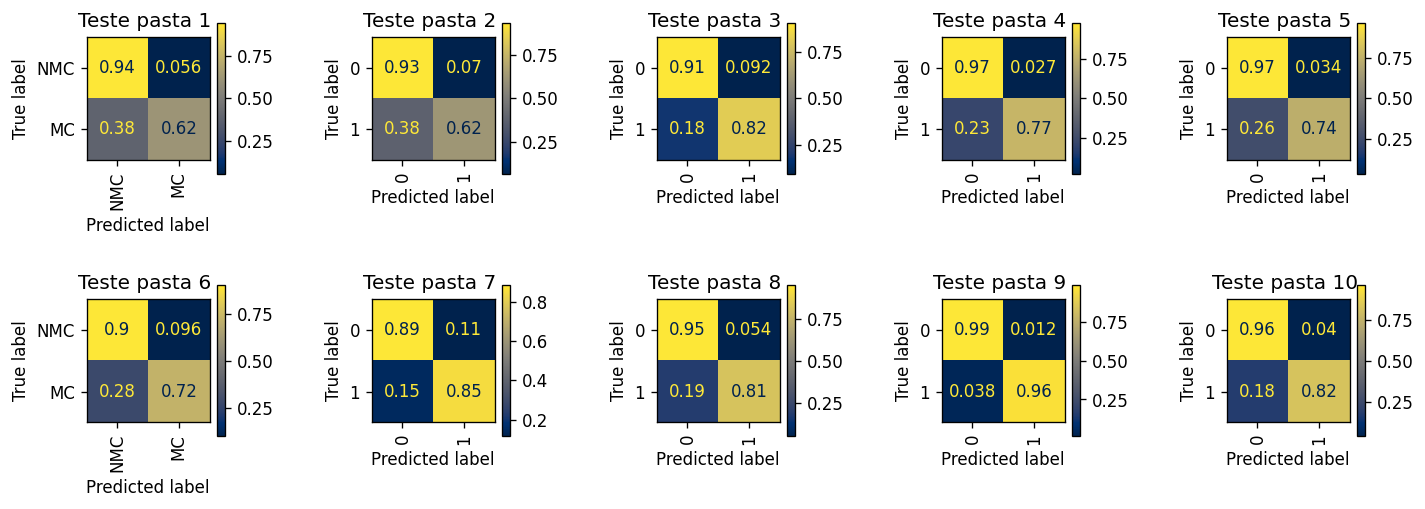

In [28]:
# Load from pre-saved file
allConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["allConfusionMatrix_AM"]

# Plot all confusion matrix
fig, axes = plt.subplots(2, 5, dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in allConfusionMatrix_AM:
    axes[idxRow][idxCol].set_title('Teste pasta ' + str(5*idxRow+idxCol+1) + ' ')
    if idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NMC', 'MC'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmPlt = cmDisplay.plot(ax=axes[idxRow][idxCol], cmap='cividis', xticks_rotation='vertical');

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
    fig.savefig(fname = logPath + '2_allConfusionMatrix.jpg' );

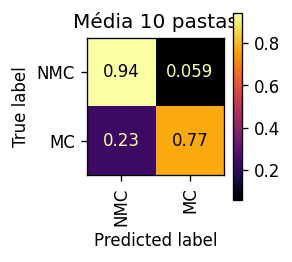

In [29]:
# Average results
confusionMatrixAvg_M = np.zeros([2,2]);
for cm in allConfusionMatrix_AM:
    confusionMatrixAvg_M += cm;
confusionMatrixAvg_M *=0.1;

# Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(2); fig.tight_layout(pad=0.5);
axes.set_title('Média 10 pastas')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixAvg_M, display_labels=['NMC', 'MC'])
cmDisplay.plot(ax=axes,  cmap='inferno', xticks_rotation='vertical')

fig.savefig(fname = logPath + '3_avgConfusionMatrix.jpg' );

# Analyze: Plot the best confusion matrices + best average

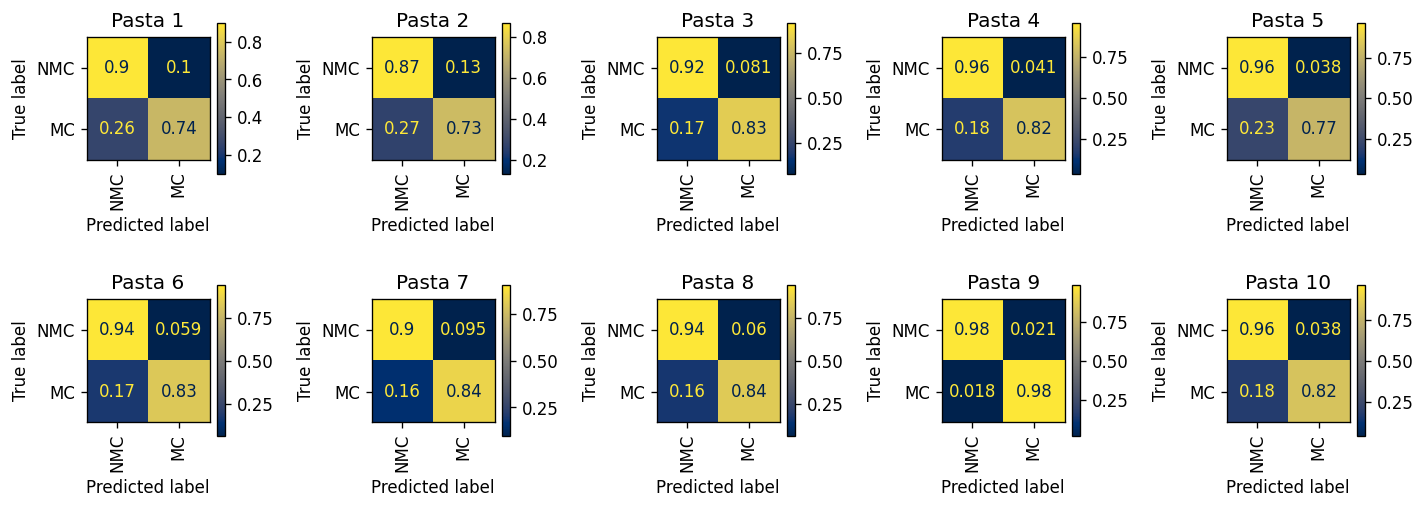

In [30]:
# Load from pre-saved file
bestConfusionMatrix_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["bestConfusionMatrix_AM"]

# Plot all confusion matrix
fig, axes = plt.subplots(2, 5, dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for cm in bestConfusionMatrix_AM:
    axes[idxRow][idxCol].set_title('Pasta ' + str(5*idxRow+idxCol+1) + '')
    if 1: #idxCol == 0:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NMC', 'MC'])
    else:
        cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmPlt = cmDisplay.plot(ax=axes[idxRow][idxCol], cmap='cividis', xticks_rotation='vertical');

    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
    fig.savefig(fname = logPath + '2b_bestConfusionMatrix.jpg' );

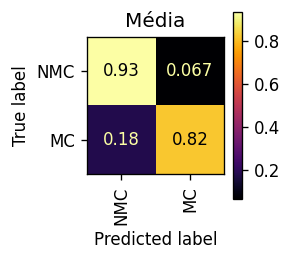

In [31]:
# Average results
bestMatrixAvg_M = np.zeros([2,2]);
for cm in bestConfusionMatrix_AM:
    bestMatrixAvg_M += cm;
bestMatrixAvg_M *=0.1;

# Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(2); fig.tight_layout(pad=0.5);
axes.set_title('Média')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=bestMatrixAvg_M, display_labels=['NMC', 'MC'])
cmDisplay.plot(ax=axes,  cmap='inferno', xticks_rotation='vertical')
fig.savefig(fname = logPath + '3b_avgConfusionMatrix.jpg' );

# Analyze: Metrics extraction

In [32]:
# Metrics
bestConfusionMatrixAbs_AM = np.load(
    "{0}/{1}.npz".format(trainingResultsPath, confusionFile), allow_pickle=True)["bestConfusionMatrixAbs_AM"]
    
accuracy_A = []; 
precision_A = []; 
sensibility_A = []; 
specificity_A = []; 
f1Score_A = [];
youdenJ_A  = [];

idx=0
for cm in bestConfusionMatrixAbs_AM:
    accuracy_A.append((cm[0,0] + cm[1,1]) / ( cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0] ));
    precision_A.append(cm[1,1] / ( cm[1,1] + cm[0,1] ));
    sensibility_A.append(cm[1,1] / ( cm[1,1] + cm[1,0] ));
    specificity_A.append(cm[0,0] / ( cm[0,0] + cm[0,1] ));
    f1Score_A.append( 2 * (precision_A[idx] * sensibility_A[idx]) / (precision_A[idx] + sensibility_A[idx]) );
    youdenJ_A.append(sensibility_A[idx] + specificity_A[idx] - 1);
    idx+=1

np.savez("{0}{1}".format(trainingResultsPath, metricsFile), accuracy_A=accuracy_A, precision_A=precision_A,
sensibility_A=sensibility_A, specificity_A=specificity_A, f1Score_A=f1Score_A, youdenJ_A=youdenJ_A);

print(accuracy_A);
print(precision_A);
print(sensibility_A);
print(specificity_A);
print(f1Score_A);
print(youdenJ_A);

[0.8219332956472584, 0.7982129560685034, 0.874062445491017, 0.8935845213849287, 0.8668323863636364, 0.8814001117110408, 0.8726032448377581, 0.8906084375662497, 0.9805064308681672, 0.8948299587183015]
[0.8732200275608636, 0.8446266724212343, 0.9064212999216915, 0.9495934959349593, 0.9518716577540107, 0.9422623723487824, 0.9056675542031191, 0.9246882793017457, 0.9780265339966833, 0.9529854254818994]
[0.7396887159533074, 0.7299515106303618, 0.8273766976411723, 0.822824938358577, 0.7688984881209503, 0.8303911388023537, 0.8431303116147308, 0.8355114916629113, 0.9816895547232626, 0.8233143785540211]
[0.8991596638655462, 0.8662207357859532, 0.9185689948892675, 0.9593842122502456, 0.9621583742116327, 0.9407735697018533, 0.9046153846153846, 0.9395516413130505, 0.9794014768752429, 0.9619047619047619]
[0.8009269012007584, 0.7831132452981192, 0.8650971599402093, 0.8816757878845065, 0.8506571087216249, 0.8827966881324747, 0.8732807628828168, 0.8778409090909092, 0.9798546209761163, 0.883416866419699

# Analyze: Train-Test history and progression

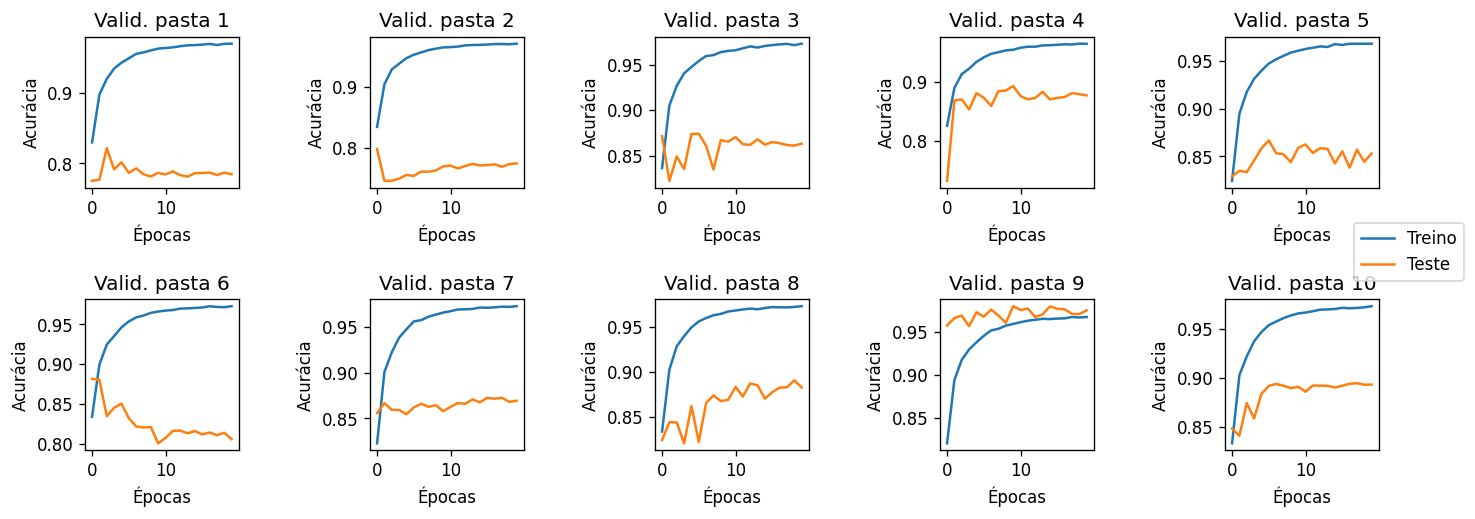

In [33]:
# Load from pre-saved file
allFitHistory_AO = np.load("{0}/{1}.npz".format(trainingResultsPath, trainingFile), allow_pickle=True)["allFitHistory_AO"]

# Plot
fig, axes = plt.subplots(2,5,dpi=120)
fig.set_figheight(10*.5); fig.set_figwidth(25*.5); fig.tight_layout(pad=4.5)

idxRow, idxCol = 0, 0
for resPlot in allFitHistory_AO:
    axes[idxRow][idxCol].set_title('Valid. pasta ' + str(5*idxRow+idxCol+1) + '')
    axes[idxRow][idxCol].plot(resPlot['accuracy']); 
    axes[idxRow][idxCol].plot(resPlot['val_accuracy']);
    axes[idxRow][idxCol].set(ylabel = 'Acurácia', xlabel= 'Épocas');
    idxCol += 1
    if idxCol == 5:
        idxCol, idxRow = 0, 1;
fig.legend(['Treino' , 'Teste'], loc=5, bbox_to_anchor=(1, 0.505), fontsize = 'medium');
fig.savefig(fname = logPath + '4_allTrainTestStats.jpg' );


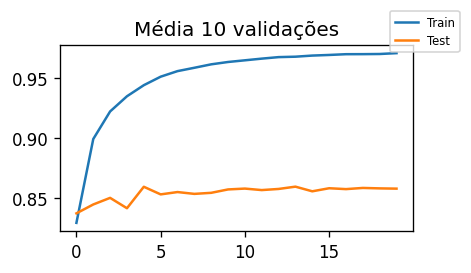

In [34]:
# Average results
avgAcc = np.zeros(np.shape(allFitHistory_AO[0]['accuracy']))
avgValAcc = np.zeros(np.shape(allFitHistory_AO[0]['val_accuracy']))
for resPlot in allFitHistory_AO:
    avgAcc += resPlot['accuracy'];
    avgValAcc += resPlot['val_accuracy'];
avgAcc*=0.1; avgValAcc*=0.1;

#Plot
fig, axes = plt.subplots(dpi=120)
fig.set_figheight(2); fig.set_figwidth(3.5); fig.tight_layout(pad=0.5);

axes.set_title('Média 10 validações')
plt.plot(avgAcc);
plt.plot(avgValAcc);
fig.legend(['Train' , 'Test'], loc=1, bbox_to_anchor=(1.075, 1.1), fontsize = 'x-small');
fig.savefig(fname = logPath + '5_avgTrainTestStats.jpg' );

# Misc: Sound segment analysis

In [35]:
# Find a non-engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 0:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!


In [36]:
# Find an engine sound
for idx in np.arange( len(train_data["classes"])  ):
    if train_data["classes"][idx] == 1:
        print('Found!');
        break;

Audio(train_data["segSounds"][idx], rate=SOUND_SR)

Found!
